1. Instalar e importar as bibliotecas necessárias

In [4]:
import cv2
import tensorflow as tf
import os
import imghdr
import numpy as np
from matplotlib import pyplot as plt

C:\Users\erick\AppData\Local\Temp\ipykernel_29352\3209713608.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


2. Carregar as imagens

Primeiro, separar as imagens por categorias com base na planilha disponibilizada no dataset!

In [ ]:
import csv
import os
import shutil

# Inicializando contadores para cada classe
counts = {
    'MEL': 0,
    'NV': 0,
    'BCC': 0,
    'AK': 0,
    'BKL': 0,
    'DF': 0,
    'VASC': 0,
    'SCC': 0,
    'UNK': 0
}

input_dir = '../data/ISIC_2019_Training_Input'
output_dir = '../data/sorted_images'


os.makedirs(output_dir, exist_ok=True)
for classe in counts.keys():
    os.makedirs(os.path.join(output_dir, classe), exist_ok=True)

# Lendo o arquivo CSV
with open('../data/ISIC_2019_Training_GroundTruth.csv', 'r') as file:
    reader = csv.reader(file)
    
    # Ignorando o cabeçalho
    next(reader)
    
    # Processando cada linha
    for row in reader:
        image_name = row[0]
        # Convertendo os valores de string para float
        values = list(map(float, row[1:]))
        
        # Atualizando contadores
        if values[0] == 1.0:
            counts['MEL'] += 1
            shutil.move(os.path.join(input_dir, image_name + ".jpg"), os.path.join(output_dir, 'MEL', image_name + '.jpg'))
        if values[1] == 1.0:
            counts['NV'] += 1
            shutil.move(os.path.join(input_dir, image_name + ".jpg"), os.path.join(output_dir, 'NV', image_name + '.jpg'))
        if values[2] == 1.0:
            counts['BCC'] += 1
            shutil.move(os.path.join(input_dir, image_name + ".jpg"), os.path.join(output_dir, 'BCC', image_name + '.jpg'))
        if values[3] == 1.0:
            counts['AK'] += 1
            shutil.move(os.path.join(input_dir, image_name + ".jpg"), os.path.join(output_dir, 'AK', image_name + '.jpg'))
        if values[4] == 1.0:
            counts['BKL'] += 1
            shutil.move(os.path.join(input_dir, image_name + ".jpg"), os.path.join(output_dir, 'BKL', image_name + '.jpg'))
        if values[5] == 1.0:
            counts['DF'] += 1
            shutil.move(os.path.join(input_dir, image_name + ".jpg"), os.path.join(output_dir, 'DF', image_name + '.jpg'))
        if values[6] == 1.0:
            counts['VASC'] += 1
            shutil.move(os.path.join(input_dir, image_name + ".jpg"), os.path.join(output_dir, 'VASC', image_name + '.jpg'))
        if values[7] == 1.0:
            counts['SCC'] += 1
            shutil.move(os.path.join(input_dir, image_name + ".jpg"), os.path.join(output_dir, 'SCC', image_name + '.jpg'))
        if values[8] == 1.0:
            counts['UNK'] += 1
            shutil.move(os.path.join(input_dir, image_name + ".jpg"), os.path.join(output_dir, 'UNK', image_name + '.jpg'))

# Exibindo os resultados
for classe, count in counts.items():
    print(f'{classe}: {count}')

Agora, de fato, carregar as imagens no kera.

Found 25331 files belonging to 8 classes.


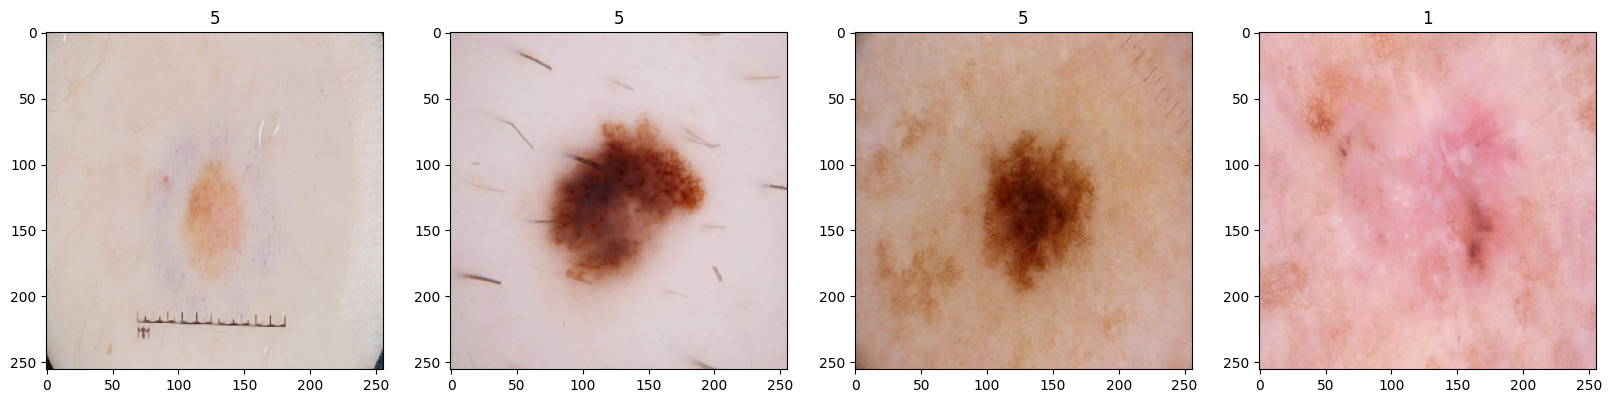

In [5]:
data = tf.keras.utils.image_dataset_from_directory('./data/sorted_images') # Carregando imagens do diretório

data_iterator = data.as_numpy_iterator() # Criando um iterador para acessar os dados

batch = data_iterator.next() # Carregando um batch de imagens

fig, ax = plt.subplots(ncols=4, figsize=(20,20)) # Criando uma figura com 4 subplots
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
# Exibindo a figura

3. Separar as imagens
- Separar os dados em 70% treinamento, 20% validação e 10% teste. O número de lotes vai depender do tamanho total da amostra!

In [11]:
data = data.map(lambda x,y: (x/255, y)) # Normalizando as imagens
# data.as_numpy_iterator().next() # Carregando um batch de imagens

train_size = int(len(data) * .7) # O conjunto de treino terá 70% dos dados
val_size = int(len(data) * .2) # O conjunto de validação terá 20%
test_size = int(len(data)* .1) # O conjunto de teste terá 10%

train = data.take(train_size) # Pegando os primeiros 70% dos dados
val = data.skip(train_size).take(val_size) # Pegando os próximos 20% dos dados
test = data.skip(train_size+val_size).take(test_size) # Pegando os últimos 10% dos dados

# Verificando um batch
for batch in train.take(1):
    images, labels = batch
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Image batch shape: (32, 256, 256, 3)
Label batch shape: (32,)


4. Construir o modelo através da solução de hiperparâmetros

- MaxPooling2D -> condensa a imagem para baixo;

- Otimização -> Adam, para ajuste de pesos e minimizar perdas

- Binary Crossentropy -> computa a perda de entropia cruzada entre labels verdadeiros e labels preditados.

In [2]:
from tensorflow.keras.models import Sequential # import sequential API. Sequential is good for 1 data input.

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout # import needed layers

from tensorflow.keras.callbacks import TensorBoard

from scikeras.wrappers import KerasClassifier

from tensorflow.keras.utils import to_categorical

import tensorflow as tf

from keras_tuner import RandomSearch


In [ ]:
train = train.map(lambda x, y: (x, to_categorical(y, num_classes=8)))
val = val.map(lambda x, y: (x, to_categorical(y, num_classes=8)))
    
def create_model(hp):
    model = Sequential()
    
    # Otimização do número de filtros na primeira camada
    model.add(Conv2D(hp.Int('filters1', min_value=16, max_value=64, step=16), (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)))
    model.add(MaxPooling2D())
    
    # Otimização do número de filtros na segunda camada
    model.add(Conv2D(hp.Int('filters2', min_value=32, max_value=128, step=32), (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D())
    
    model.add(Flatten())
    
    # Otimização do número de unidades na camada densa
    model.add(Dense(hp.Int('units', min_value=128, max_value=512, step=128), activation='relu'))
    
    # Otimização da taxa de dropout
    model.add(Dropout(hp.Float('dropout_rate', 0, 0.5, step=0.1)))
    
    model.add(Dense(8, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Inicializando o Keras Tuner
tuner = RandomSearch(
    create_model,
    objective='val_accuracy',
    max_trials=10,  # Número máximo de combinações de hiperparâmetros a serem testadas
    executions_per_trial=1,
    directory='my_dir',
    project_name='cancer_model_tuning'
)

# Executando a busca
tuner.search(train, validation_data=val, epochs=10)

# Obtendo os melhores hiperparâmetros
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Melhores hiperparâmetros: {best_hyperparameters.values}")


Agora sim, construindo o modelo baseado do melhor hiperparâmetro:

In [ ]:
# Criando e treinando o modelo com os melhores hiperparâmetros
model = tuner.hypermodel.build(best_hyperparameters)
history = model.fit(train, validation_data=val, epochs=10)
history.save('cancer_model.h5')

Caso haja algum problema por causa do venv e o script acima não rode, é possível rodar manualmente a criação do modelo com base no resultado dos melhores hiperparametros:
- Filtro 1: 32
- Filtro 2: 64
- Unidades: 128
- Dropout: 0.4

In [8]:
train = train.map(lambda x, y: (x, to_categorical(y, num_classes=8)))
val = val.map(lambda x, y: (x, to_categorical(y, num_classes=8)))

# Usando os melhores hiperparâmetros que foram retornados pelo tuner
filters1 = 32
filters2 = 64
units = 128
dropout_rate = 0.4

# Definindo o modelo
model = Sequential()

# Primeira camada de convolução e max pooling com os melhores filtros
model.add(Conv2D(filters1, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

# Segunda camada de convolução e max pooling com os melhores filtros
model.add(Conv2D(filters2, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D())

# Camada de Flatten para converter a saída em uma dimensão
model.add(Flatten())

# Camada densa com o melhor número de unidades e dropout
model.add(Dense(units, activation='relu'))
model.add(Dropout(dropout_rate))

# Camada de saída com softmax para 8 classes
model.add(Dense(8, activation='softmax'))

# Compilando o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Treinando o modelo
history = model.fit(train, validation_data=val, epochs=10)

# Salvando o modelo treinado
model.save('best_cancer_model.keras')
print("Modelo salvo como 'best_cancer_model.keras'")

Epoch 1/10
554/554 ━━━━━━━━━━━━━━━━━━━━ 493s 887ms/step - accuracy: 0.4799 - loss: 2.0733 - val_accuracy: 0.5237 - val_loss: 1.3259
Epoch 2/10
554/554 ━━━━━━━━━━━━━━━━━━━━ 442s 798ms/step - accuracy: 0.5325 - loss: 1.3252 - val_accuracy: 0.5479 - val_loss: 1.2466
Epoch 3/10
554/554 ━━━━━━━━━━━━━━━━━━━━ 493s 889ms/step - accuracy: 0.5586 - loss: 1.2297 - val_accuracy: 0.5740 - val_loss: 1.1839
Epoch 4/10
554/554 ━━━━━━━━━━━━━━━━━━━━ 474s 855ms/step - accuracy: 0.5726 - loss: 1.1860 - val_accuracy: 0.5809 - val_loss: 1.1728
Epoch 5/10
554/554 ━━━━━━━━━━━━━━━━━━━━ 465s 838ms/step - accuracy: 0.5921 - loss: 1.1444 - val_accuracy: 0.5831 - val_loss: 1.1763
Epoch 6/10
554/554 ━━━━━━━━━━━━━━━━━━━━ 419s 755ms/step - accuracy: 0.6111 - loss: 1.0748 - val_accuracy: 0.5955 - val_loss: 1.1493
Epoch 7/10
554/554 ━━━━━━━━━━━━━━━━━━━━ 420s 757ms/step - accuracy: 0.6391 - loss: 1.0095 - val_accuracy: 0.5920 - val_loss: 1.1449
Epoch 8/10
554/554 ━━━━━━━━━━━━━━━━━━━━ 430s 776ms/step - accuracy: 0.6518 -

Modelo salvo como 'best_cancer_model.h5'


5. Matriz de Confusão
- Hora de criar a matriz de confusão do modelo

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 169ms/step


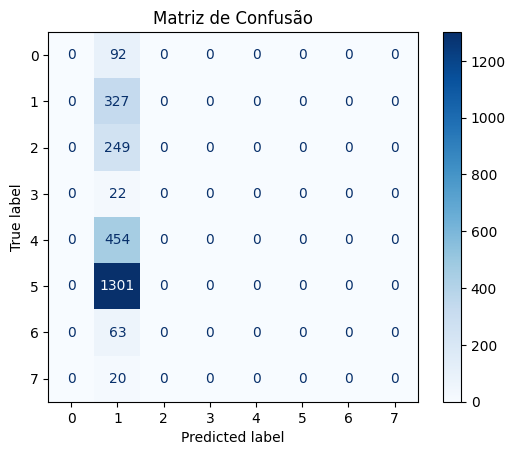

In [14]:
# Carregar o modelo salvo
model = tf.keras.models.load_model('melanoma_model_v4.h5')

# Obter as previsões para o conjunto de teste
test_images = []
test_labels = []

# Extraindo as imagens e os rótulos do conjunto de teste
for images, labels in test:
    test_images.append(images)
    test_labels.append(labels)

# Convertendo listas para arrays
test_images = np.concatenate(test_images, axis=0)
test_labels = to_categorical(np.concatenate(test_labels, axis=0))

# Obter previsões
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Gerar matriz de confusão
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plotar matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(8))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.show()